In [67]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import matplotlib.patches as pat

from tqdm.autonotebook import tqdm, trange

In [2]:
ds, info = tfds.load('coco/2017', with_info = True)
#ds, info = tfds.load('cosmos_qa', with_info = True)

In [3]:
print(info)

tfds.core.DatasetInfo(
    name='coco',
    version=1.1.0,
    description='COCO is a large-scale object detection, segmentation, and
captioning dataset. This version contains images, bounding boxes "
and labels for the 2017 version.
Note:
 * Some images from the train and validation sets don't have annotations.
 * Coco 2014 and 2017 uses the same images, but different train/val/test splits
 * The test split don't have any annotations (only images).
 * Coco defines 91 classes but the data only uses 80 classes.
 * Panotptic annotations defines defines 200 classes but only uses 133.',
    homepage='http://cocodataset.org/#home',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'image/id': tf.int64,
        'objects': Sequence({
            'area': tf.int64,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'id': tf.int64,
            'is_crowd': tf.bool,
 

In [40]:
class Boxes:
    """
    Utility class holding various methods for bounding box processing.
    """
    
    @staticmethod
    def xxyy_to_cwh(x1, y1, x2, y2):
        """Converts from corner- to center-based format"""
        cx = 0.5 * (x1 + x2)
        cy = 0.5 * (y1 + y2)
        w = tf.abs(x2 - x1)
        h = tf.abs(y1 - y2)
        
        return cx, cy, w, h
    
    @staticmethod
    def area(x1, y1, x2, y2):
        """Computes the area of corner-based box"""
        return tf.abs((x2 - x1) * (y2 - y1))
    
    @staticmethod
    def intersect(x1, y1, x2, y2):
        """Intersects to bounding boxes in corner-based format"""
        x = (x1, x2)
        y = (y1, y2)
        
        x1 = tf.math.minimum(*x)
        y1 = tf.math.minimum(*y)
        x2 = tf.math.maximum(*x)
        y2 = tf.math.maximum(*y)
            
        x1 = tf.math.reduce_max(x1, axis = -1)
        y1 = tf.math.reduce_max(y1, axis = -1)
        x2 = tf.math.reduce_min(x2, axis = -1)
        y2 = tf.math.reduce_min(y2, axis = -1)
        
        y2 = tf.where(y2 > y1, y2, y1)
        x2 = tf.where(x2 > x1, x2, x1)
        
        return x1, y1, x2, y2
    
    @staticmethod
    def iou(x1, y1, x2, y2):
        """
        Approximates intersection-over-union (IOU) metric for a set of boxes as area(intersection) / (sum(areas) - area(intersection))
        Approximation is exact for box pairs, more numbers will lead to under-estimation
        """
        #tf.print(x1, y1, x2, y2)
        #tf.print(*Boxes.intersect(x1, y2, x2, y2))
        #tf.print('Box')
        #tf.print(x1, y1, x2, y2)
        #tf.print('Intersection')
        #tf.print(*Boxes.intersect(x1, y2, x2, y2))
        inter = Boxes.area(*Boxes.intersect(x1, y1, x2, y2))
        
        union = tf.math.reduce_sum(Boxes.area(x1, y1, x2, y2), axis = -1) - inter
        
        #tf.print('Box')
        #tf.print(x1, y1, x1, y2)
        #tf.print('Inter')
        #tf.print(*Boxes.intersect(x1, y1, x2, y2))
        #tf.print('AInter')
        #tf.print(inter)
        
        return inter / union
    
class FeatureDomain(tf.Module):
    """
    Class representing the desired output feature domain structure, and utility methods to deal with its cell structure
    The data here should be used by feature extractors to check compatibility and compute a desired input size
    """
    def __init__(self, cell_w = 10, cell_h = 10, n_x = 10, n_y = 10):
        self.cell_w = cell_w
        self.cell_h = cell_h
        
        self.n_x = n_x
        self.n_y = n_y
        
    def global_to_cell(self, x1, y1, x2, y2):
        """
        Computes the intra-cell position of a bounding box from a global position
        """
        cx, cy, w, h = Boxes.xxyy_to_cwh(y1, y1, x2, y2)
        
        cellno_x = tf.math.minimum(tf.cast(cx * self.n_x, tf.int64), self.n_x)
        cellno_y = tf.math.minimum(tf.cast(cy * self.n_y, tf.int64), self.n_y)
        
        cell_x = cx * self.n_x - tf.cast(cellno_x, tf.float32)
        cell_y = cy * self.n_y - tf.cast(cellno_y, tf.float32)        
        return cellno_x, cellno_y, cell_x, cell_y, w, h
    
    def same_cell_iou(self, cell_x, cell_y, w, h):
        """
        Adjusts the length of coordinate systems and then performs IOU metric over last axis
        Assumes that all boxes of one IOU group are related to the same cell (no position adjustment based on cell id)
        """
        x = cell_x / self.n_x
        y = cell_y / self.n_y
        
        return Boxes.iou(cell_x - 0.5 * w, cell_y - 0.5 * h, cell_x + 0.5 * w, cell_y + 0.5 * h)

class AnchorBoxes(tf.Module):
    """
    Class that helps with the setup and selection of anchor boxes in a given feature domain.
    Contains both the data of the anchor boxes, and methods for selecting appropriate anchors
    """
    def __init__(self, feature_domain, n_anchors = 5):
        self.feature_domain = feature_domain
        
        # TODO: Random initialization
        def anchor_var():
            return tf.Variable(tf.random.uniform(shape = [n_anchors], dtype = tf.float32))
        self.cx = anchor_var()
        self.cy = anchor_var()
        self.w  = anchor_var()
        self.h  = anchor_var()
    
    def closest_anchor(self, cx, cy, w, h):
        dom = self.feature_domain
        
        # Appends dimension to first argument, then broadcasts to compatible shape, then stacks
        def merge(a, b):
            a = a[...,None]
            shape = tf.broadcast_dynamic_shape(tf.shape(a), tf.shape(b))
            
            a = tf.broadcast_to(a, shape)
            b = tf.broadcast_to(b, shape)
            
            return tf.stack([a, b], axis = -1)
                
        ious = dom.same_cell_iou(
            merge(cx, self.cx),
            merge(cy, self.cy),
            merge(w , self.w),
            merge(h , self.h)
        )
        
        #tf.print('IOUs')
        #tf.print(ious)
        
        # Select box with highest overlap
        isel = tf.math.argmax(ious, axis = -1)
        
        batch_dims = len(isel.shape)
        
        #anchor_cx = tf.gather(self.cx, isel, axis = -1)
        #anchor_cy = tf.gather(self.cy, isel, axis = -1)
        #anchor_w = tf.gather(self.cw, isel, axis = -1)
        #anchor_h = tf.gather(self.ch, isel, axis = -1)
        
        return isel, tf.gather(ious, isel, axis = -1, batch_dims = batch_dims)

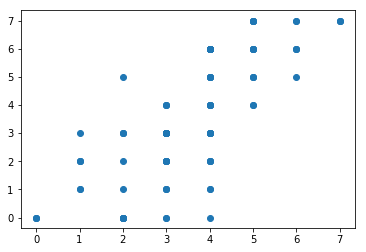

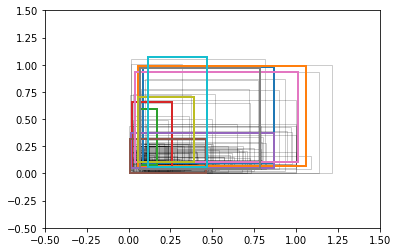

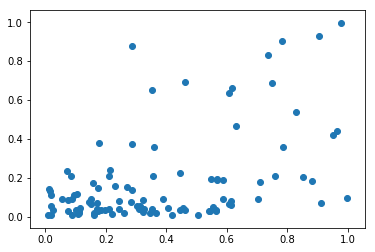

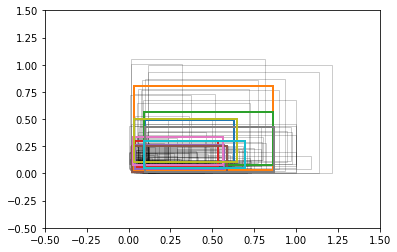

In [74]:
#def boxdata(plot = False):

fd = FeatureDomain(cell_w = 10, cell_h = 10, n_x = 8, n_y = 8)
anchors = AnchorBoxes(fd, 10)

@tf.function
def boxdata(k):
    obj = k['objects']

    idx = tf.range(tf.shape(obj['bbox'])[0])

    ilabel = obj['label']
    cellx, celly, cx, cy, w, h = fd.global_to_cell(*tf.unstack(obj['bbox'], axis = -1))

    result = {
        'cell' : (cellx, celly),
        'center' : (cx, cy),
        'wh' : (w, h),
        'ilabel' : ilabel
    }
    
    return tf.data.Dataset.from_tensor_slices(result)

@tf.function
def anchor_loss(cell, center, wh, **kwargs):
    isel, iou = anchors.closest_anchor(*center, *wh)
    return -tf.reduce_mean(iou)

optimizer = tf.keras.optimizers.Adam(1e-2) 

@tf.function
def apply_ds(d):
    def loss():
        return anchor_loss(**d)

    optimizer.minimize(
        loss,
        anchors.trainable_variables
    )           

    return loss()

def box_plot(k):
    plt.figure()
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    ax = plt.gca()
    
    def add_patches(x, y, w, h, edgecolor = None, **kwargs):
        x = x / fd.n_x
        y = y / fd.n_y
        
        for i in range(tf.shape(x)[0]):
            ec = 'C{}'.format(i) if edgecolor is None else edgecolor
            patch = pat.Rectangle((x[i], y[i]), x[i] + w[i], y[i] + h[i], facecolor='none', edgecolor = ec, **kwargs)
            ax.add_patch(patch)
    
    add_patches(*k['center'], *k['wh'], alpha = 0.2, edgecolor = 'black')
    add_patches(anchors.cx, anchors.cy, anchors.w, anchors.h, linewidth = 2)
    
myds = ds['train'].flat_map(boxdata).take(100000).batch(100).cache()

for k in myds.take(1):
    plt.figure()
    plt.scatter(*k['cell'])
    
    box_plot(k)
    
    plt.figure()
    plt.scatter(*k['wh'])

plt.show()

with tqdm(myds) as t:
    for d in t:
        loss = apply_ds(d)
        
        t.set_postfix(dict(Loss = loss))

for k in myds.take(1):    
    box_plot(k)

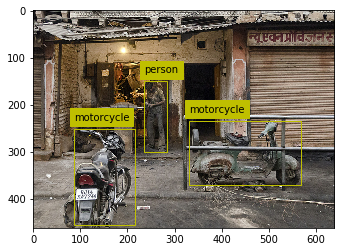

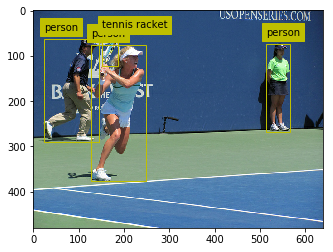

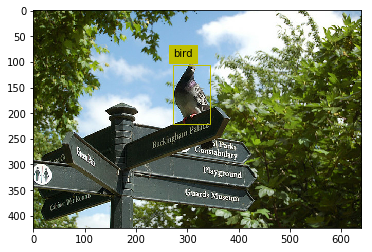

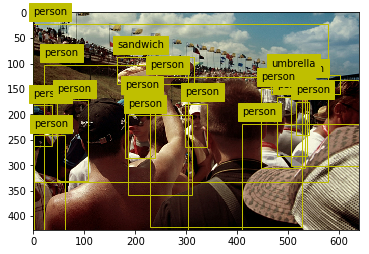

In [76]:
for k in ds['train'].take(4):
    plt.imshow(k['image'])
    
    indices = range(len(k['objects']['bbox']))
    
    for i in indices:
        box = k['objects']['bbox'][i]
        ilabel = k['objects']['label'][i]
        slabel = info.features['objects']['label'].int2str(ilabel)
        ax = plt.gca()
                
        y1, x1, y2, x2 = box
        y1 = 1 - y1
        y2 = 1 - y2
        patch = pat.Rectangle((x1, y1), x2 - x1, y2 - y1, transform = ax.transAxes, facecolor='none', edgecolor = 'y')
        plt.annotate(slabel, (x1, y1 + 0.03), xycoords = ax.transAxes, verticalalignment = 'bottom', backgroundcolor = 'y')
        ax.add_patch(patch)
    
    plt.show()